In [71]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# PySAL Libraries
from libpysal import weights
from libpysal.weights import Queen, DistanceBand, lag_spatial
import libpysal
from pysal.explore import esda
from esda.moran import Moran

# Contextily (for map tiles)
import contextily as ctx

## Research Question ##

Does the availability of sports facilities, reported victimization and amount of traffic influence performance in mathematics among primary school pupils? 

# Variables #

# Independent variables (datasets Sports, Safety and Traffic) #

Sports facilities per 1000 inhabitants 

Safety index: reported victimization index 

Nuisance: amount of traffic 

# Dependent variable (Dataset Education): #

Primary school target level maths (%)

In [72]:
# Define and import datasets

dfSport = pd.read_excel("C:/Users/eppez/Downloads/Sports.xlsx")
dfTraffic = pd.read_excel("C:/Users/eppez/Downloads/Traffic.xlsx")
dfSafety = pd.read_excel("C:/Users/eppez/Downloads/Safety.xlsx")
dfEducation = pd.read_excel("C:/Users/eppez/Downloads/Education.xlsx")
dfGeo = pd.read_csv("C:/Users/eppez/Downloads/Geometry of Wijks.csv")



In [73]:
dfEducation

,Geography,Area,Area code,Year,theme,Pre-primary education: indications,Pre-primary education: participating indications,Pre-primary education: % indications,Pre-primary education: % participaton indications,Primary education: schools,...,students hbo (%),students wo (%),Special education: schools,Special education: pupils,Secondary education: % pupils with primary school/vmbo educated parents,Secondary education: % students with middle educated parents,% School advice PRO/VMBO-BK,% School advice VMBO -GT/HAVO,Special primary education: schools,Special primary education: pupils
0,Wijken,Haarlemmerbuurt,AA,2021,Education,23,13,24,57,1,...,2,3.5,-,-,-,-,-,-,-,-
1,Wijken,Jordaan,AB,2021,Education,21,11,14,52,2,...,2.7,4.6,1,40,6,17,-,-,-,-
2,Wijken,Grachtengordel-West,AC,2021,Education,5,-,7,-,1,...,2.1,6.5,-,-,-,-,-,-,-,-
3,Wijken,Burgwallen-Nieuwe Zijde,AD,2021,Education,5,-,20,-,-,...,4.3,9.3,-,-,-,-,-,-,-,-
4,Wijken,Burgwallen-Oude Zijde,AE,2021,Education,5,-,4,-,-,...,4.8,9.7,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Wijken,IJburg-Oost,MK,2021,Education,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
104,Wijken,Bloemendalerpolder,SB,2021,Education,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
105,Wijken,Weesp Binnenstad/Zuid,SD,2021,Education,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
106,Wijken,Aetsveld/Oostelijke Vechtoever,SE,2021,Education,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [74]:
# Merge relevant columns from datasets based on neighbourhood data

df_combined = dfSport.merge(dfTraffic, on='Area code', suffixes=('', '_traffic')) \
                     .merge(dfSafety, on='Area code', suffixes=('', '_safety')) \
                     .merge(dfEducation, on='Area code', suffixes=('', '_safety'))

print(df_combined.head())

  Geography                     Area Area code  Year   theme  \
0    Wijken          Haarlemmerbuurt        AA  2021  Sports   
1    Wijken                  Jordaan        AB  2021  Sports   
2    Wijken      Grachtengordel-West        AC  2021  Sports   
3    Wijken  Burgwallen-Nieuwe Zijde        AD  2021  Sports   
4    Wijken    Burgwallen-Oude Zijde        AE  2021  Sports   

  Sports facilities (1-10) Sports: facilities total Sports: accomodations  \
0                      6.5                        6                     1   
1                      6.2                       18                     1   
2                        6                        5                     1   
3                        5                        4                     -   
4                      4.9                        -                     -   

  Sports: fitness Sports: indoors  ... students hbo (%) students wo (%)  \
0               2               2  ...                2             3.5   
1 

In [75]:
# Adjust Geodata to 

dfGeo.rename(columns={'Wijkcode': 'Area code'}, inplace=True)

dfGeo.head()

dfGeo = dfGeo.applymap(lambda x: x.replace('"', '').replace("'", '') if isinstance(x, str) else x)

dfGeo.head()

C:\Users\eppez\AppData\Local\Temp\ipykernel_14912\3542107196.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfGeo = dfGeo.applymap(lambda x: x.replace('"', '').replace("'", '') if isinstance(x, str) else x)


,OBJECTNUMMER,CBS_Wijkcode,Area code,Wijk,Gebiedcode,Gebied,Stadsdeelcode,Stadsdeel,Oppervlakte_m2,WKT_LNG_LAT,WKT_LAT_LNG,LNG,LAT,geometry
0,1.0,BU0363EQ,EQ,Da Costabuurt,GE05,"Oud-West, De Baarsjes",E,West,257542.0,"POLYGON((4.867406 52.371797,4.869586 52.368605...","POLYGON((52.371797 4.867406,52.368605 4.869586...",4.872108,52.370130,"POLYGON ((4.867406 52.371797, 4.869586 52.3686..."
1,2.0,BU0363ER,ER,Westindische Buurt,GE05,"Oud-West, De Baarsjes",E,West,345503.0,"POLYGON((4.848885 52.358045,4.848892 52.357914...","POLYGON((52.358045 4.848885,52.357914 4.848892...",4.854062,52.361007,"POLYGON ((4.848885 52.358045, 4.848892 52.3579..."
2,3.0,BU0363KB,KB,Schinkelbuurt,GK11,Oud-Zuid,K,Zuid,344932.0,"POLYGON((4.848181 52.342768,4.849791 52.342924...","POLYGON((52.342768 4.848181,52.342924 4.849791...",4.852877,52.349646,"POLYGON ((4.848181 52.342768, 4.849791 52.3429..."
3,4.0,BU0363KC,KC,Willemspark,GK11,Oud-Zuid,K,Zuid,695818.0,"POLYGON((4.855085 52.35641,4.855027 52.356322,...","POLYGON((52.35641 4.855085,52.356322 4.855027,...",4.862796,52.354371,"POLYGON ((4.855085 52.35641, 4.855027 52.35632..."
4,5.0,BU0363KD,KD,Museumkwartier,GK11,Oud-Zuid,K,Zuid,1380178.0,"POLYGON((4.86554 52.358854,4.867135 52.356104,...","POLYGON((52.358854 4.86554,52.356104 4.867135,...",4.876464,52.355265,"POLYGON ((4.86554 52.358854, 4.867135 52.35610..."


In [76]:
# Ensure 'Area code' is present and has the correct type in both DataFrames
df_combined['Area code'] = df_combined['Area code'].astype(str)
dfGeo['Area code'] = dfGeo['Area code'].astype(str)

# Perform the merge with suffixes to handle overlapping column names
df_combined = df_combined.merge(dfGeo, on='Area code', suffixes=('', '_geo'))

# Display the first few rows of the merged DataFrame
print(df_combined.head())

  Geography                     Area Area code  Year   theme  \
0    Wijken          Haarlemmerbuurt        AA  2021  Sports   
1    Wijken                  Jordaan        AB  2021  Sports   
2    Wijken      Grachtengordel-West        AC  2021  Sports   
3    Wijken  Burgwallen-Nieuwe Zijde        AD  2021  Sports   
4    Wijken    Burgwallen-Oude Zijde        AE  2021  Sports   

  Sports facilities (1-10) Sports: facilities total Sports: accomodations  \
0                      6.5                        6                     1   
1                      6.2                       18                     1   
2                        6                        5                     1   
3                        5                        4                     -   
4                      4.9                        -                     -   

  Sports: fitness Sports: indoors  ... Gebiedcode        Gebied Stadsdeelcode  \
0               2               2  ...       GA01  Centrum-West        

In [77]:
df_combined.replace('-', None, inplace=True)

In [78]:
#check for missing values
for col in df_combined.columns:
    print(col, np.sum(df_combined[col].isnull()))



Geography 0
Area 0
Area code 0
Year 0
theme 0
Sports facilities (1-10) 1
Sports: facilities total 9
Sports: accomodations 52
Sports: fitness 49
Sports: indoors 53
Sports: other 35
Sports facilities per 1.000 residents 9
Sports: outdoors 63
Sports: water 84
Geography_traffic 0
Area_traffic 0
Year_traffic 0
theme_traffic 0
Nuisance: speeding traffic (%) 6
Nuisance: aggressive behaviour in traffic (%) 6
Nuisance: parking problems (%) 6
Parking spots total 0
Parking spots fiscal 12
Parking spots non public 0
Parking facilities (1-10) 1
Parking facilities bikes (1-10) 0
Nuisance: parking (1-10) 1
Public transport (1-10) 0
Public transport 65+ (1-10) 16
Nuisance: amount of traffic (1-10) 0
Nuisance: traffic noise (1-10) 0
Parking spots non-fiscal 61
Geography_safety Geography_safety    0
Geography_safety    0
dtype: int64
Area_safety Area_safety    0
Area_safety    0
dtype: int64
Year_safety Year_safety    0
Year_safety    0
dtype: int64
theme_safety theme_safety    0
theme_safety    0
dtype

c:\Users\eppez\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [79]:
df_combined = df_combined[['Area', 'Area code', 'Safety index: reported victimization index', 'Nuisance: amount of traffic (1-10)', 'Sports facilities per 1.000 residents', 'primary school target level maths (%)', 'geometry', 'Oppervlakte_m2']]
df_combined.head()

,Area,Area code,Safety index: reported victimization index,Nuisance: amount of traffic (1-10),Sports facilities per 1.000 residents,primary school target level maths (%),geometry,Oppervlakte_m2
0,Haarlemmerbuurt,AA,75,6.8,0.65,48,"POLYGON ((4.881667 52.38418, 4.882537 52.38392...",811434.0
1,Jordaan,AB,111,6.6,0.93,64,"POLYGON ((4.875487 52.37341, 4.875432 52.37323...",942953.0
2,Grachtengordel-West,AC,164,6.8,0.79,51,"POLYGON ((4.886206 52.378089, 4.883155 52.3747...",566891.0
3,Burgwallen-Nieuwe Zijde,AD,154,6.4,0.99,None,"POLYGON ((4.891315 52.376324, 4.891181 52.3761...",725676.0
4,Burgwallen-Oude Zijde,AE,134,6.7,None,None,"POLYGON ((4.899692 52.377303, 4.899141 52.3769...",403162.0


In [80]:
#check for missing values
for col in df_combined.columns:
    print(col, np.sum(df_combined[col].isnull()))

Area 0
Area code 0
Safety index: reported victimization index 6
Nuisance: amount of traffic (1-10) 0
Sports facilities per 1.000 residents 9
primary school target level maths (%) 15
geometry 1
Oppervlakte_m2 1


To ensure the soundness of our analysis we decided to drop all missing values.

In [81]:
df_combined.shape

(99, 8)

In [82]:
df_combined = df_combined.dropna()

In [83]:
#check for missing values again to check if it worked
for col in df_combined.columns:
    print(col, np.sum(df_combined[col].isnull()))

Area 0
Area code 0
Safety index: reported victimization index 0
Nuisance: amount of traffic (1-10) 0
Sports facilities per 1.000 residents 0
primary school target level maths (%) 0
geometry 0
Oppervlakte_m2 0


In [84]:
df_combined.shape

(78, 8)

This means we dropped 20 neighborhoods because they lacked data.

In [85]:
df_combined.to_csv('MergedDataGroup12.1.csv', index=False)

In [86]:
# Summarize using descriptive statistics
a = 'MergedDataGroup12.1.csv'
da = pd.read_csv(a, header=None)
da.columns = da.loc[0]
da = da.drop(index = 0)
da.head()

print(da.info())
print(da.isnull().sum())
print(da.describe())

print(da.head())

keyvalue_dict = {col: da[col].iloc[0] for col in da.columns}
print(keyvalue_dict)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 1 to 78
Data columns (total 8 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Area                                        78 non-null     object
 1   Area code                                   78 non-null     object
 2   Safety index: reported victimization index  78 non-null     object
 3   Nuisance: amount of traffic (1-10)          78 non-null     object
 4   Sports facilities per 1.000 residents       78 non-null     object
 5   primary school target level maths (%)       78 non-null     object
 6   geometry                                    78 non-null     object
 7   Oppervlakte_m2                              78 non-null     object
dtypes: object(8)
memory usage: 5.0+ KB
None
0
Area                                          0
Area code                                     0
Safety index: reported victimizatio

In [87]:

import statsmodels.api as sm

print(df_combined.dtypes)

# Convert Y and X to numeric
Y = pd.to_numeric(df_combined['primary school target level maths (%)'], errors='coerce')


Area                                           object
Area code                                      object
Safety index: reported victimization index     object
Nuisance: amount of traffic (1-10)             object
Sports facilities per 1.000 residents          object
primary school target level maths (%)          object
geometry                                       object
Oppervlakte_m2                                float64
dtype: object


In [88]:
# Define the dependent variable
Y = pd.to_numeric(df_combined['primary school target level maths (%)'], errors='coerce')

# Define independent variables
X1 = pd.to_numeric(df_combined['Sports facilities per 1.000 residents'], errors='coerce')
X2 = pd.to_numeric(df_combined['Safety index: reported victimization index'], errors='coerce')
X3 = pd.to_numeric(df_combined['Nuisance: amount of traffic (1-10)'], errors='coerce')

# Create a function to compute R-squared for a given independent variable
def calculate_r_squared(X, Y):
    X = sm.add_constant(X)  # Add a constant to the model
    model = sm.OLS(Y, X).fit()  # Fit the model
    return model.rsquared  # Return R-squared value

Text(0, 0.5, 'Frequency')

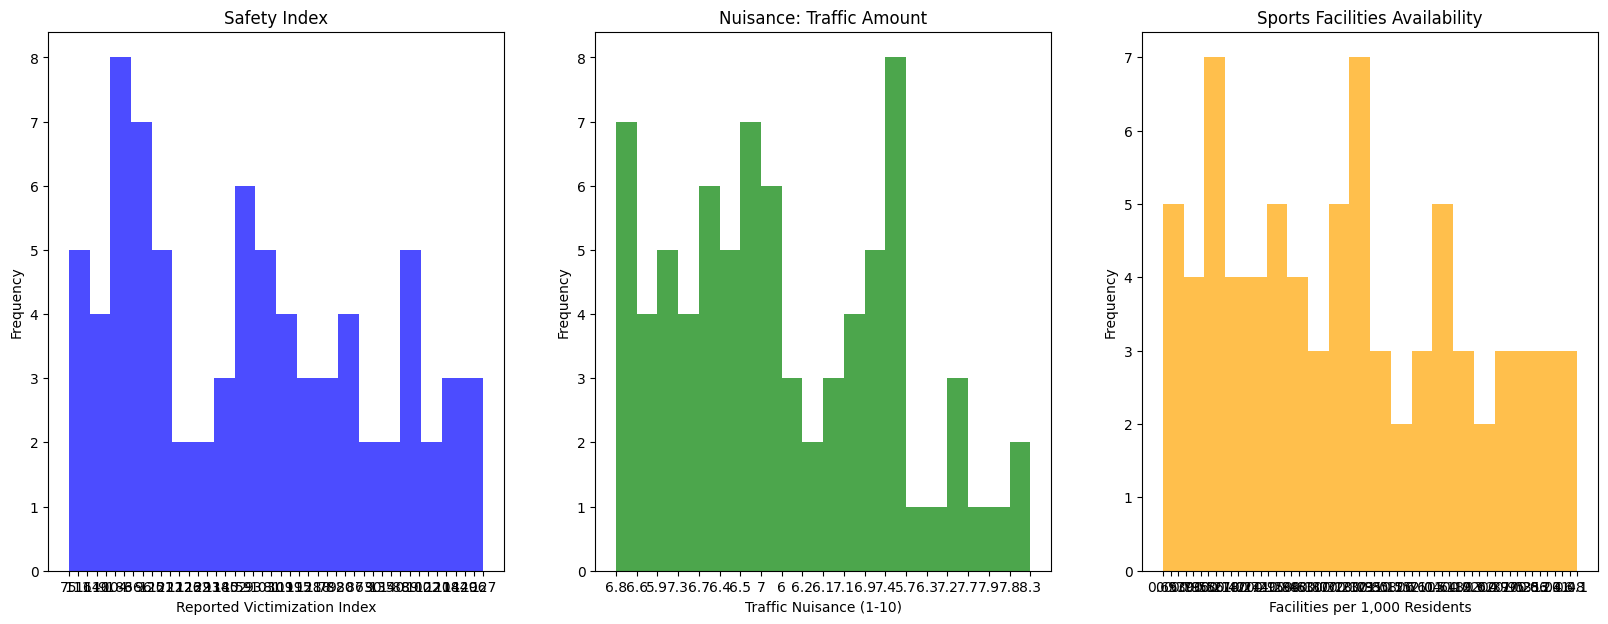

In [89]:
#Compute histograms to visualize distribution

f, axs = plt.subplots(1,3,figsize = (20,7)) 
axs[0].hist(da['Safety index: reported victimization index'], bins=20, color='blue', alpha=0.7) 
axs[0].set_title('Safety Index') 
axs[0].set_xlabel('Reported Victimization Index') 
axs[0].set_ylabel('Frequency')  

axs[1].hist(da['Nuisance: amount of traffic (1-10)'], bins=20, color='green', alpha=0.7) 
axs[1].set_title('Nuisance: Traffic Amount') 
axs[1].set_xlabel('Traffic Nuisance (1-10)') 
axs[1].set_ylabel('Frequency') 

axs[2].hist(da['Sports facilities per 1.000 residents'], bins=20, color='orange', alpha=0.7) 
axs[2].set_title('Sports Facilities Availability') 
axs[2].set_xlabel('Facilities per 1,000 Residents') 
axs[2].set_ylabel('Frequency') 

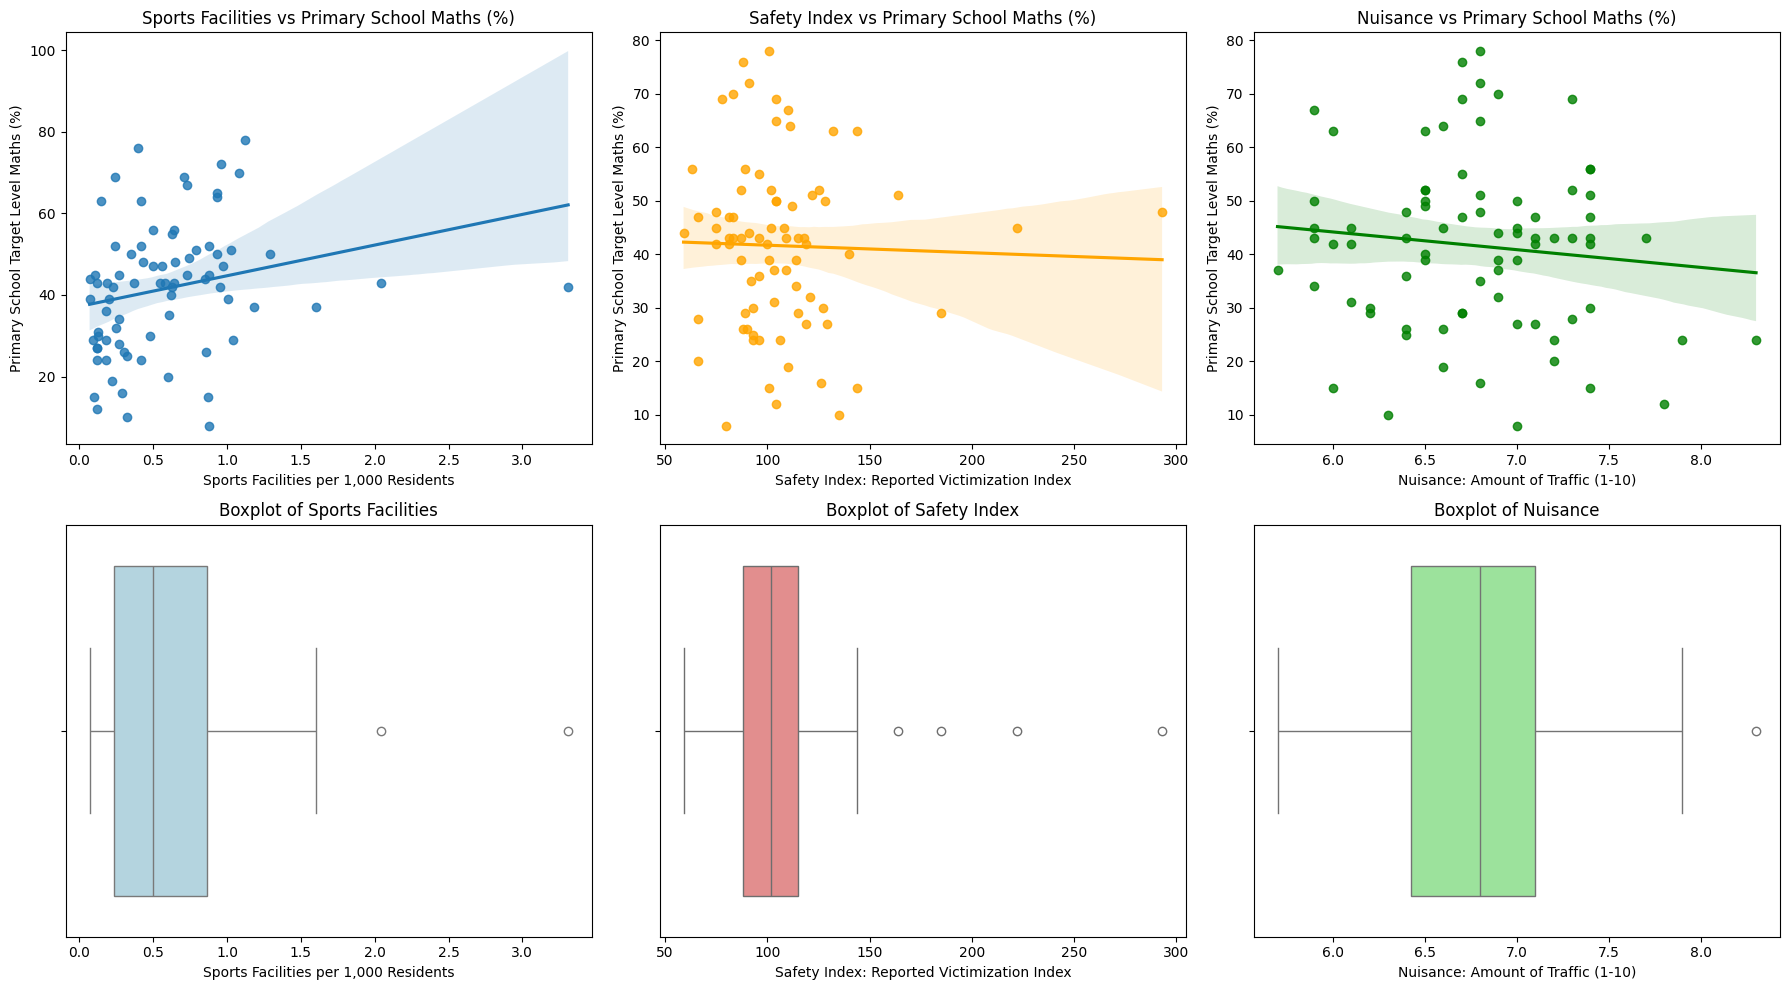

In [90]:
# Figure for subplots
plt.figure(figsize=(18, 10))

# Libneair regression and boxplot for Sports facilities
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, 1st subplot
sns.regplot(x=X1, y=Y)
plt.title('Sports Facilities vs Primary School Maths (%)')
plt.xlabel('Sports Facilities per 1,000 Residents')
plt.ylabel('Primary School Target Level Maths (%)')

plt.subplot(2, 3, 4)  # 2 rows, 3 columns, 4th subplot
sns.boxplot(x=X1, color='lightblue')
plt.title('Boxplot of Sports Facilities')
plt.xlabel('Sports Facilities per 1,000 Residents')

# Lineair regression and boxplot for Safety index
plt.subplot(2, 3, 2)  # 2 rows, 3 columns, 2nd subplot
sns.regplot(x=X2, y=Y, color='orange')
plt.title('Safety Index vs Primary School Maths (%)')
plt.xlabel('Safety Index: Reported Victimization Index')
plt.ylabel('Primary School Target Level Maths (%)')

plt.subplot(2, 3, 5)  # 2 rows, 3 columns, 5th subplot
sns.boxplot(x=X2, color='lightcoral')
plt.title('Boxplot of Safety Index')
plt.xlabel('Safety Index: Reported Victimization Index')

# Lineair regression and boxplot for Nuisance
plt.subplot(2, 3, 3)  # 2 rows, 3 columns, 3rd subplot
sns.regplot(x=X3, y=Y, color='green')
plt.title('Nuisance vs Primary School Maths (%)')
plt.xlabel('Nuisance: Amount of Traffic (1-10)')
plt.ylabel('Primary School Target Level Maths (%)')

plt.subplot(2, 3, 6)  # 2 rows, 3 columns, 6th subplot
sns.boxplot(x=X3, color='lightgreen')
plt.title('Boxplot of Nuisance')
plt.xlabel('Nuisance: Amount of Traffic (1-10)')

# Layout and display
plt.tight_layout()
plt.show()

In [91]:
# Create a function to compute R-squared for a given independent variable
def calculate_r_squared(X, Y):
    X = sm.add_constant(X)  # Add a constant to the model
    model = sm.OLS(Y, X).fit()  # Fit the model
    return model.rsquared  # Return R-squared value

# Calculate R-squared for each independent variable
r_squared_X1 = calculate_r_squared(X1, Y)
r_squared_X2 = calculate_r_squared(X2, Y)
r_squared_X3 = calculate_r_squared(X3, Y)

# Print R-squared values
print(f'R-squared for Sports Facilities: {r_squared_X1:.4f}')
print(f'R-squared for Safety Index: {r_squared_X2:.4f}')
print(f'R-squared for Nuisance: {r_squared_X3:.4f}')

R-squared for Sports Facilities: 0.0557
R-squared for Safety Index: 0.0009
R-squared for Nuisance: 0.0122


## Conclusion ##

In the end, the independent variables we selected as potential significant predictors were either insignificant or yielded miniscule R squared, pointing to the low predictive power of the model. We were able to ascertain a positive corelation between children’s performance in math and amount of sport facilities but the effect of the independent variable on the dependent one is very limited.